In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import shutil
import torch
from torch import nn
import torch.utils.data
import torch.nn.functional as F
import torch.optim as optim
import random
import time

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [2]:
class ECGDataset(torch.utils.data.Dataset):
    
    def __init__(self,path):
        self.data=pd.read_csv(path,header=None)
        
    def __getitem__(self,idx):
        x=self.data.loc[idx,:186].values # removed the label
        return x
    
    def __len__(self):
        return len(self.data)
        

torch.Size([64, 187]) torch.float64


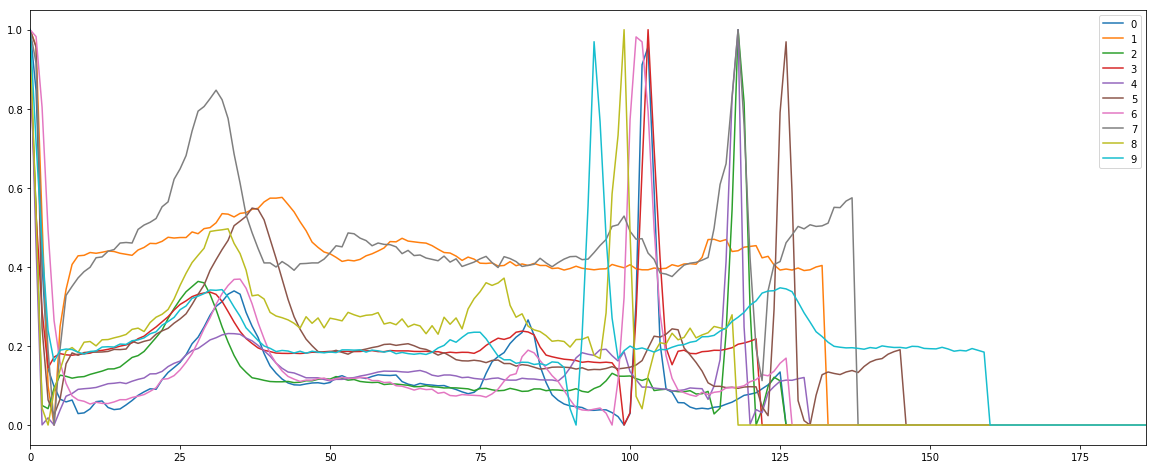

In [3]:
root_path="../input/ecg-data-mit-arrhythmia-ptb"
cuda=torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
    
class opt:
    batch_size=64
    workers=2
    lr=0.001
    normal_train_path=root_path+"/normal_train.csv"
    normal_valid_path=root_path+"/normal_valid.csv"
    patient_valid_path=root_path+"/patient_valid.csv"
    

normal_train_dset=ECGDataset(opt.normal_train_path)
trainloader=torch.utils.data.DataLoader(normal_train_dset,
                                       batch_size=opt.batch_size,
                                       shuffle=True,
                                        num_workers=opt.workers)

for x in trainloader:
    print(x.shape,x.dtype)
    x=x.numpy()
    x=pd.DataFrame(x)
    x.iloc[:10,:].T.plot(figsize=(20,8))
    plt.show() #plot to check the data pipeline is working well
    break

In [9]:
class Autoencoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        #conv1d(in_channel,out_channel,kernel_size,stride,padding,bias=True,)
        #input=batch_size*187*1
        self.Encoder=nn.Sequential(
            
            nn.Conv1d(1,2,8),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),#batch_size*90*2
            
            nn.Conv1d(2,4,11),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),#batch_size*40*4
            
            nn.Conv1d(4,8,11),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),#batch_size*15*4
            
            nn.Conv1d(8,16,6),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),#batch_size*5*4
            
            nn.Conv1d(16,32,5),
            nn.ReLU(inplace=True),#batch_size*1*32
        )
        
        #convtranspose1d(in_channel,out_channel,kernel_size,stride,padding,output_padding,bias=True)
        #input=batch_size*1*32
        self.Decoder=nn.Sequential(
            
            nn.ConvTranspose1d(32,16,15,1,0),#batch_size*15*16
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose1d(16,8,12,2,0),#batch_size*40*8
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose1d(8,4,12,2,0),#batch_size*90*4
            nn.Sigmoid(),
            
            nn.ConvTranspose1d(4,2,12,2,5),#batch_size*180*2
            nn.Sigmoid(),
            
            nn.ConvTranspose1d(2,1,8,1,0),#batch_size*180*1
            nn.Sigmoid(),
        )
        
    def forward(self,inp):
        inp=inp.view(-1,1,187)
        latent_vector=self.Encoder(inp)
        fake_signal=self.Decoder(latent_vector)
        
        return fake_signal.view(-1,187)

In [11]:
network=Autoencoder().to(device)
optimizer=optim.Adam(network.parameters(),lr=opt.lr)

def loss_function(pred,real):
    #criterion=nn.MSELoss(reduction="sum")
    mse=F.mse_loss(pred,real,reduction="sum")
    return mse

In [6]:
total_loss=[]
network.train()
t1=time.time()
for epoch in range(50):
    loss_count=0
    for i,signal in enumerate(trainloader):

        signal=signal.to(device).float()

        output=network(signal)
        loss=loss_function(output,signal)
        loss_count+=loss.item()

        network.zero_grad()
        loss.backward()
        optimizer.step()

    
    total_loss.append(loss_count)
    if(epoch%9==0):
        print("Epoch : {} Loss : {}".format(epoch,loss_count))
        torch.save(network.state_dict(),"klconv_epoch_{}.pt".format(epoch))

t2=time.time()
time_taken=(t2-t1)/60
print(f"Total Time Taken : {time_taken:.2f}")

Epoch : 0 Loss : 377315.6118707657
Epoch : 1 Loss : 147879.90261936188
Epoch : 2 Loss : 114018.00003063679
Epoch : 3 Loss : 97831.05096638203
Epoch : 4 Loss : 87490.0909883976
Epoch : 5 Loss : 80073.87330281734
Epoch : 6 Loss : 75013.25144946575
Epoch : 7 Loss : 70933.33001422882
Epoch : 8 Loss : 67378.05511307716
Epoch : 9 Loss : 64269.83424723148
Epoch : 10 Loss : 62288.06224513054
Epoch : 11 Loss : 60067.937734246254
Epoch : 12 Loss : 58501.20070362091
Epoch : 13 Loss : 56609.36343753338
Epoch : 14 Loss : 55132.5352717638
Epoch : 15 Loss : 54299.51863193512
Epoch : 16 Loss : 52666.208188414574
Epoch : 17 Loss : 52060.759139955044
Epoch : 18 Loss : 50531.55447047949
Epoch : 19 Loss : 49981.79318976402
Epoch : 20 Loss : 49326.91281795502
Epoch : 21 Loss : 48061.88744419813
Epoch : 22 Loss : 47620.327467262745
Epoch : 23 Loss : 47198.37774562836
Epoch : 24 Loss : 46142.81986761093
Epoch : 25 Loss : 45946.95728582144
Epoch : 26 Loss : 45337.188148736954
Epoch : 27 Loss : 44963.643342971

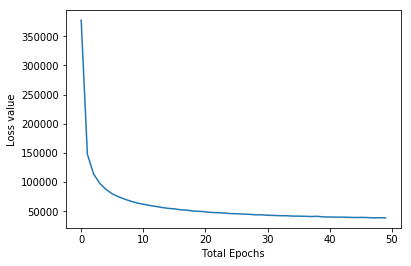

In [7]:
plt.plot(list(range(len(total_loss))),total_loss)
plt.xlabel("Total Epochs")
plt.ylabel("Loss value")
plt.show()